In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Harry Bridges Plaza (Ferry Building)の需要予測

In [2]:
trip1 = pd.read_csv('/home/kyohei/bike_share_data/201402_babs_open_data/201402_trip_data.csv')
trip2 = pd.read_csv('/home/kyohei/bike_share_data/201408_babs_open_data/201408_trip_data.csv')
trip3 = pd.read_csv('/home/kyohei/bike_share_data/201508_trip_data.csv')
trip4 = pd.read_csv('/home/kyohei/bike_share_data/201608_trip_data.csv')

In [3]:
#trip1のcolumns名の変更
trip1.rename(columns={'Subscription Type':'Subscriber Type'},inplace=True)

In [4]:
#tripdataの結合
trip = pd.concat([trip1,trip2,trip3,trip4],axis=0,ignore_index=True)

In [5]:
#tripのスタートターミナルの限定
trip_hbp_start = trip[trip['Start Terminal']==50]

#datetimeに変換
trip_hbp_start['Start Date'] = trip_hbp_start['Start Date'].apply(lambda x:pd.to_datetime(x))

#年
trip_hbp_start['start_year'] = trip_hbp_start['Start Date'].apply(lambda x:x.date().year)

#月
trip_hbp_start['start_month'] = trip_hbp_start['Start Date'].apply(lambda x:x.date().month)

#曜日
trip_hbp_start['start_dayofweek'] = trip_hbp_start['Start Date'].apply(lambda x:x.dayofweek)

import datetime
#時刻
trip_hbp_start['start_time'] = trip_hbp_start['Start Date'].apply(lambda x:x.time())

#hour
trip_hbp_start['hour'] = trip_hbp_start['Start Date'].apply(lambda x:x.hour)

#時刻hour
trip_hbp_start['start_time_hour'] = trip_hbp_start['Start Date'].apply(lambda x:datetime.datetime(x.year,x.month,x.day,x.hour))

/home/kyohei/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/kyohei/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/kyohei/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stabl

### weather

In [6]:
weather1 = pd.read_csv('/home/kyohei/bike_share_data/201402_babs_open_data/201402_weather_data.csv')
weather2 = pd.read_csv('/home/kyohei/bike_share_data/201408_babs_open_data/201408_weather_data.csv')
weather3 = pd.read_csv('/home/kyohei/bike_share_data/201508_weather_data.csv')
weather4 = pd.read_csv('/home/kyohei/bike_share_data/201608_weather_data.csv')

In [7]:
#columnsの修正
weather2.columns = weather2.columns.str.strip()
weather3.columns = weather3.columns.str.strip()
weather4.columns = weather4.columns.str.strip()
weather1.columns = weather2.columns
weather4.rename(columns={'ZIP':'Zip'},inplace=True)

In [8]:
#weatherの統合
weather = pd.concat([weather1,weather2,weather3,weather4],axis=0)

In [9]:
#dateの変換
weather['PDT'] = weather['PDT'].apply(lambda x:pd.to_datetime(x))

In [10]:
weather_SF = weather[weather.Zip==95113]

### status

In [11]:
status1 = pd.read_csv('/home/kyohei/bike_share/data_split_2013/San Francisco_station_status_stid50.csv')
status2 = pd.read_csv('/home/kyohei/bike_share/data_split_2014/San Francisco_station_status_stid50.csv')
status3 = pd.read_csv('/home/kyohei/bike_share/data_split_2015/San Francisco_station_status_stid50.csv')

In [12]:
status = pd.concat([status1,status2,status3],axis=0)

In [13]:
#datetime
status['time'] = status['time'].apply(lambda x:pd.to_datetime(x))

#時間情報
status['time_hour_minute'] = status['time'].apply(lambda x:datetime.time(x.time().hour,x.time().minute))

In [14]:
status = status.reset_index()

In [15]:
status.head()

,index,Unnamed: 0,station_id,bikes_available,docks_available,time,time_hour_minute
0,0,9809414,50,7,16,2013-08-29 12:06:01,12:06:00
1,1,9809415,50,7,16,2013-08-29 12:07:01,12:07:00
2,2,9809416,50,7,16,2013-08-29 12:08:01,12:08:00
3,3,9809417,50,7,16,2013-08-29 12:09:01,12:09:00
4,4,9809418,50,7,16,2013-08-29 12:10:01,12:10:00


In [16]:
status['time'] = status['time'].apply(lambda x:datetime.datetime(x.year,x.month,x.day,x.hour,x.minute))

### 統合前のデータ準備

In [76]:
#目的変数の作成
target = pd.DataFrame(trip_hbp_start.groupby('start_time_hour').size()).reset_index()

#columnの変換
target.rename(columns={0:'Count'},inplace=True)

In [77]:
target.head()

,start_time_hour,Count
0,2013-08-29 11:00:00,4
1,2013-08-29 12:00:00,10
2,2013-08-29 13:00:00,3
3,2013-08-29 14:00:00,2
4,2013-08-29 15:00:00,4


In [36]:
#weather
T_mapping = {'T':0}
f = lambda x:T_mapping.get(x,x)
weather_SF['PrecipitationIn'] = weather_SF.PrecipitationIn.map(f).astype(float)

/home/kyohei/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [37]:
#weather
event_dummy = pd.get_dummies(weather_SF.Events)

weather_SF_mod = pd.concat([weather_SF,event_dummy],axis=1)

weather_SF_sub = weather_SF_mod.drop(['Events','Max Gust SpeedMPH','Zip'],axis=1)

#前日データ
weather_SF_sub_yesterday = pd.concat([weather_SF_sub[['PDT']],weather_SF_sub.shift(1).drop(['PDT'],axis=1)],axis=1).dropna()

In [34]:
status.head()

,index,Unnamed: 0,station_id,bikes_available,docks_available,time,time_hour_minute
0,0,9809414,50,7,16,2013-08-29 12:06:00,12:06:00
1,1,9809415,50,7,16,2013-08-29 12:07:00,12:07:00
2,2,9809416,50,7,16,2013-08-29 12:08:00,12:08:00
3,3,9809417,50,7,16,2013-08-29 12:09:00,12:09:00
4,4,9809418,50,7,16,2013-08-29 12:10:00,12:10:00


In [39]:
status['minute'] = status['time'].apply(lambda x:x.minute)

In [45]:
status_sub = status[status['minute']==0]

In [46]:
status_sub.head()

,index,Unnamed: 0,station_id,bikes_available,docks_available,time,time_hour_minute,minute
48,48,9809462,50,9,14,2013-08-29 13:00:00,13:00:00,0
101,101,9809515,50,7,16,2013-08-29 14:00:00,14:00:00,0
157,157,9809571,50,8,15,2013-08-29 15:00:00,15:00:00,0
211,211,9809625,50,13,10,2013-08-29 16:00:00,16:00:00,0
266,266,9809680,50,6,17,2013-08-29 17:00:00,17:00:00,0


In [47]:
#Status
#status_sub = status[['bikes_available','docks_available','time','time_hour_minute']]

#年
status_sub['year'] = status_sub['time'].apply(lambda x:x.year)

#月
status_sub['month'] = status_sub['time'].apply(lambda x:x.month)

#曜日
status_sub['dayofweek'] = status_sub['time'].apply(lambda x:x.dayofweek)
weekday = {0:'monday',1:'tuseday',2:'wednseday',3:'thursday',4:'friday',5:'saturday',6:'sunday'}
status_sub['dayofweek'] = status_sub['dayofweek'].map(weekday)

#時
status_sub['hour'] = status_sub['time'].apply(lambda x:x.hour)

#日付
status_sub['day'] = status['time'].apply(lambda x:pd.to_datetime(x.date()))

/home/kyohei/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/kyohei/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/kyohei/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stabl

In [48]:
#dummy変数づくり
#年
dummy_year = pd.get_dummies(status_sub.year,prefix='year')

#時刻
#dummy_time = pd.get_dummies(status_sub.time_hour_minute)
dummy_hour = pd.get_dummies(status_sub.hour,prefix='time')

#月
dummy_month = pd.get_dummies(status_sub.month,prefix='month')

#曜日
dummy_weekday = pd.get_dummies(status_sub.dayofweek)


In [49]:
status_sub.head()

,index,Unnamed: 0,station_id,bikes_available,docks_available,time,time_hour_minute,minute,year,month,dayofweek,hour,day
48,48,9809462,50,9,14,2013-08-29 13:00:00,13:00:00,0,2013,8,thursday,13,2013-08-29
101,101,9809515,50,7,16,2013-08-29 14:00:00,14:00:00,0,2013,8,thursday,14,2013-08-29
157,157,9809571,50,8,15,2013-08-29 15:00:00,15:00:00,0,2013,8,thursday,15,2013-08-29
211,211,9809625,50,13,10,2013-08-29 16:00:00,16:00:00,0,2013,8,thursday,16,2013-08-29
266,266,9809680,50,6,17,2013-08-29 17:00:00,17:00:00,0,2013,8,thursday,17,2013-08-29


In [66]:
#一時間前のデータ
status_hour_one_hour_ago = status_sub.shift(1)[['bikes_available','docks_available']]

In [68]:
#dummyの統合
status_train = pd.concat([dummy_year,dummy_hour,dummy_month,dummy_weekday,status_hour_one_hour_ago,status_sub[['time','day']]],axis=1).dropna()

In [70]:
status_train.head()

,year_2013,year_2014,year_2015,year_2016,time_0,time_1,time_2,time_3,time_4,time_5,...,monday,saturday,sunday,thursday,tuseday,wednseday,bikes_available,docks_available,time,day
101,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,9.0,14.0,2013-08-29 14:00:00,2013-08-29
157,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,7.0,16.0,2013-08-29 15:00:00,2013-08-29
211,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,8.0,15.0,2013-08-29 16:00:00,2013-08-29
266,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,13.0,10.0,2013-08-29 17:00:00,2013-08-29
320,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,6.0,17.0,2013-08-29 18:00:00,2013-08-29


### 天気、ステータス、目的変数の統合

In [71]:
data = status_train.merge(weather_SF_sub_yesterday,left_on='day',right_on='PDT',how='inner')

In [75]:
target.head()

,Count
start_time_hour,
2013-08-29 11:00:00,4
2013-08-29 12:00:00,10
2013-08-29 13:00:00,3
2013-08-29 14:00:00,2
2013-08-29 15:00:00,4


In [78]:
data_comp = data.merge(target,left_on='time',right_on='start_time_hour',how='left')

In [79]:
data_comp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25952 entries, 0 to 25951
Data columns (total 78 columns):
year_2013                    25952 non-null float64
year_2014                    25952 non-null float64
year_2015                    25952 non-null float64
year_2016                    25952 non-null float64
time_0                       25952 non-null float64
time_1                       25952 non-null float64
time_2                       25952 non-null float64
time_3                       25952 non-null float64
time_4                       25952 non-null float64
time_5                       25952 non-null float64
time_6                       25952 non-null float64
time_7                       25952 non-null float64
time_8                       25952 non-null float64
time_9                       25952 non-null float64
time_10                      25952 non-null float64
time_11                      25952 non-null float64
time_12                      25952 non-null float64
time_13

In [80]:
data_comp_sub = data_comp.drop(['time','day','PDT','start_time_hour'],axis=1)

In [82]:
data_comp_sub.fillna(0,inplace=True)

In [162]:
simple_feature = ['bikes_available','time_0','time_1','time_2','time_3','time_4','time_5','time_6','time_7','time_8','time_9'
                 ,'time_10','time_11','time_12','time_13','time_14','time_15','time_16','time_17','time_18','time_19','time_20'
                  ,'time_21','time_22','time_23','monday','friday','saturday','sunday','thursday','tuseday','wednseday'
                 ,'Fog','Fog-Rain','Rain','Rain-Thunderstorm']

In [84]:
y = data_comp_sub['Count']
X = data_comp_sub.drop('Count',axis=1)

In [85]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25952 entries, 0 to 25951
Data columns (total 73 columns):
year_2013                    25952 non-null float64
year_2014                    25952 non-null float64
year_2015                    25952 non-null float64
year_2016                    25952 non-null float64
time_0                       25952 non-null float64
time_1                       25952 non-null float64
time_2                       25952 non-null float64
time_3                       25952 non-null float64
time_4                       25952 non-null float64
time_5                       25952 non-null float64
time_6                       25952 non-null float64
time_7                       25952 non-null float64
time_8                       25952 non-null float64
time_9                       25952 non-null float64
time_10                      25952 non-null float64
time_11                      25952 non-null float64
time_12                      25952 non-null float64
time_13

In [86]:
from sklearn.cross_validation import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0)

In [87]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
#std_columns = ['bikes_available','docks_available','Max TemperatureF','Mean TemperatureF','Min TemperatureF','Max Dew PointF',
#'MeanDew PointF','Min DewpointF','Max Humidity','Mean Humidity','Min Humidity','Max Sea Level PressureIn',
#'Mean Sea Level PressureIn','Min Sea Level PressureIn','Max Wind SpeedMPH','Mean Wind SpeedMPH','PrecipitationIn',
#'CloudCover','WindDirDegrees']
std.fit(X_train)
X_train_std = std.transform(X_train)
X_test_std = std.transform(X_test)

In [88]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

models = [LinearRegression(),
         DecisionTreeRegressor(),
         KNeighborsRegressor(),
         RandomForestRegressor()]


for model in models:
    model.fit(X_train_std,y_train)
    print('%s train_socre:%.3f' %(model.__class__.__name__,model.score(X_train_std,y_train)))
    print('%s test_score:%.3f' %(model.__class__.__name__,model.score(X_test_std,y_test)))
    print('\n')


LinearRegression train_socre:0.494
LinearRegression test_score:0.490


DecisionTreeRegressor train_socre:1.000
DecisionTreeRegressor test_score:0.453


KNeighborsRegressor train_socre:0.736
KNeighborsRegressor test_score:0.616


RandomForestRegressor train_socre:0.941
RandomForestRegressor test_score:0.685




In [93]:
data_comp_sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25952 entries, 0 to 25951
Data columns (total 74 columns):
year_2013                    25952 non-null float64
year_2014                    25952 non-null float64
year_2015                    25952 non-null float64
year_2016                    25952 non-null float64
time_0                       25952 non-null float64
time_1                       25952 non-null float64
time_2                       25952 non-null float64
time_3                       25952 non-null float64
time_4                       25952 non-null float64
time_5                       25952 non-null float64
time_6                       25952 non-null float64
time_7                       25952 non-null float64
time_8                       25952 non-null float64
time_9                       25952 non-null float64
time_10                      25952 non-null float64
time_11                      25952 non-null float64
time_12                      25952 non-null float64
time_13

In [111]:
data_8 = data_comp_sub[data_comp_sub['time_8']==1.]

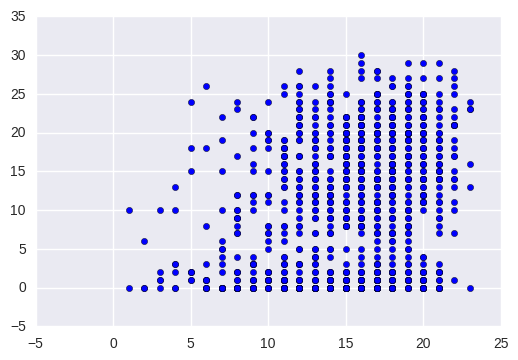

In [112]:
plt.scatter(data_8.bikes_available,data_8.Count)

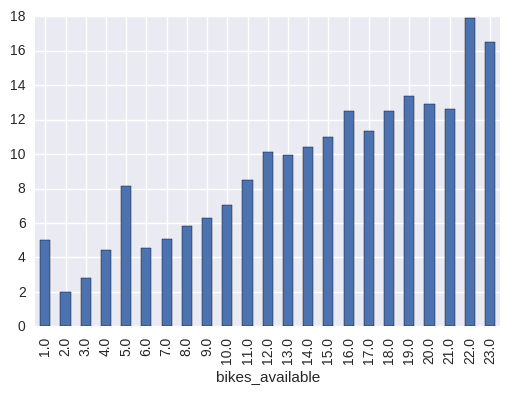

In [113]:
(data_8.groupby('bikes_available')['Count'].sum() / data_8.groupby('bikes_available')['Count'].size()).plot(kind='bar')

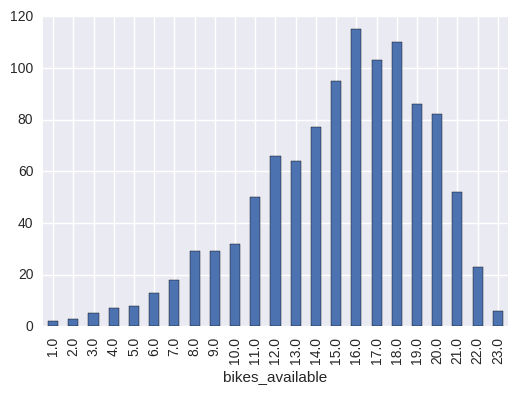

In [114]:
data_8.groupby('bikes_available')['Count'].size().plot(kind='bar')

In [124]:
trip_hbp_start[(trip_hbp_start.hour==8) & (trip_hbp_start.dayofweek<=4)].head()

,Trip ID,Duration,Start Date,Start Station,Start Terminal,End Date,End Station,End Terminal,Bike #,Subscriber Type,Zip Code,start_year,start_month,start_dayofweek,start_time,hour,start_time_hour,dayofweek
1053,5178,638,2013-08-30 08:39:00,Harry Bridges Plaza (Ferry Building),50,8/30/2013 8:50,Powell Street BART,39,564,Subscriber,94102,2013,8,4,08:39:00,8,2013-08-30 08:00:00,4
1075,5143,678,2013-08-30 08:02:00,Harry Bridges Plaza (Ferry Building),50,8/30/2013 8:13,Embarcadero at Sansome,60,539,Subscriber,94110,2013,8,4,08:02:00,8,2013-08-30 08:00:00,4
1272,5163,1209,2013-08-30 08:24:00,Harry Bridges Plaza (Ferry Building),50,8/30/2013 8:44,Embarcadero at Sansome,60,607,Customer,83714,2013,8,4,08:24:00,8,2013-08-30 08:00:00,4
1281,5149,1238,2013-08-30 08:08:00,Harry Bridges Plaza (Ferry Building),50,8/30/2013 8:28,South Van Ness at Market,66,270,Subscriber,94945,2013,8,4,08:08:00,8,2013-08-30 08:00:00,4
1456,5182,36255,2013-08-30 08:42:00,Harry Bridges Plaza (Ferry Building),50,8/30/2013 18:47,Harry Bridges Plaza (Ferry Building),50,350,Customer,94707,2013,8,4,08:42:00,8,2013-08-30 08:00:00,4


In [120]:
trip_hbp_start['dayofweek'] = trip_hbp_start['Start Date'].apply(lambda x:x.dayofweek)

/home/kyohei/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [123]:
trip_hbp_start[(trip_hbp_start.hour==8) & (trip_hbp_start.dayofweek<=4)]['Subscriber Type'].value_counts()

Subscriber    11456
Customer        338
Name: Subscriber Type, dtype: int64

In [127]:
trip_hbp_start[(trip_hbp_start.hour==8) & (trip_hbp_start.dayofweek<=4)].groupby('start_time_hour').size().mean()

15.39686684073107